## IOT / OT Cybersecurity

Cybersecurity is the protection of networks and computer systems, including hardware and software, against cyberattacks. Of particular interest to engineers is the computer control of physical systems that monitor and control transportation, pipelines, water treatment, waste treatment, chemical manufacture, factories, energy production, and other industrial processes. Two areas of cybersecurity focus are:

- Information Technology (IT): computer systems including software, data, and networks
- Operational Technology (OT): devices that control the physical world

OT Cybersecurity is concerned with keeping intruders out of the local control system network and detecting malicious intent from those who have access. Malicious intent may be subtle such as signal manipulation to decrease production, damage equipment, or steal information. One of the first notable cyberattacks was the Stuxnet virus that replayed normal data to the operator to run undetected while damaging equipment over a period of months.

Machine Learning for Cybersecurity has many applications that detect phishing, password strength, abnormal network packet flow, intrusions, spam, malware, ransomware, distributed denial of service (DDoS), and other cyberattacks. Most of ML Cybersecurity is focused on classification to detect bad actors.

<img width=550px src='https://apmonitor.com/pds/uploads/Main/equipment_monitoring.png'>

Operational Technology (OT) includes computer systems and equipment that make changes to the physical world. Sensors, actuators, and computer control systems are critical to safe operation and are increasingly under threat of attack. Industrial sectors include transportation, manufacturing, energy production, power generation, grid networks, and pipelines. A self-driving car has actuators such as steering direction, motor torque, and brake action. Airplane actuators include engine thrust, aileron angle, and flap position. Industrial chemical process actuators include valves and pumps. It is imperative that the commanded actuator is implemented as requested. There may be a difference between the commanded and actual state of the actuator if there is a cyberattack or equipment malfunction. Cyberattacks may be stealth changes to a process that go undetected but that cause equipment failure, lost economic potential, or HSE (Health, Safety, Environmental) incidents.

This is a case study with an IOT device [TCLab](https://apmonitor.com/heat.htm) where the heater (actuator) is monitored to determine if it is **on** or **off**. The predicted and commanded heater states are compared to determine if there is an equipment failure or external actor that has taken control of the heater.

**Objective:** Develop a classifier to predict when the TCLab heater is on and when it is off. Generate labeled data where the heater is either on at 100% output or at 0% output for periods between 10 and 25 seconds. See [IOT/OT Cybersecurity](https://apmonitor.com/pds/index.php/Main/ActuatorMonitor) for additional instructions.

### Connect TCLab

<img src='https://apmonitor.com/pdc/uploads/Main/tclab_connect.png'>

Toggle `tclab_connected` to `True` if [TCLab](https://apmonitor.com/heat.htm) device is connected. Otherwise, the exercise uses sample data or values generated from a [TCLab digital twin (simulation)](https://tclab.readthedocs.io/en/latest/README.html).

In [1]:
tclab_connected=False  # True (if TCLab is connected)

### Generate Test Data

Generate test data with 10 minutes of alternating the heater on and off.

In [2]:
# generate new data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tclab
import time

if tclab_connected:
    # TCLab hardware
    lab = tclab.TCLab()
else:
    # digital twin
    TCLab = tclab.setup(connected=False, speedup=50)
    lab = TCLab()    

n = 600  # Number of second time points (10 min)
tm = np.linspace(0,n,n+1) # Time values
T1 = [lab.T1]
T2 = [lab.T2]
Q1 = np.zeros(n+1)
Q2 = np.zeros(n+1)
# turn on heater at select times
Q1[20:41]   = 100.0; Q1[60:91]   = 100.0; Q1[150:181] = 100.0
Q1[190:206] = 100.0; Q1[220:251] = 100.0; Q1[260:291] = 100.0
Q1[300:316] = 100.0; Q1[340:351] = 100.0; Q1[400:431] = 100.0
Q1[500:521] = 100.0; Q1[540:571] = 100.0
for i in range(n):
    lab.Q1(Q1[i]); lab.Q2(Q2[i])
    if tclab_connected:
        # sleep 1 second
        time.sleep(1)
        if i%10==0: print(Q1[i],lab.T1)
    else:
        # digital twin has 50x speedup
        time.sleep(0.02)
        # print every 50th cycle
        if i%50==0: print(Q1[i],lab.T1)
    T1.append(lab.T1); T2.append(lab.T2)
lab.close()
# Save data file
data = np.vstack((tm,Q1,Q2,T1,T2)).T
np.savetxt('tclab_test.csv',data,delimiter=',',\
           header='Time,Q1,Q2,T1,T2',comments='')

TCLab version 0.4.9
Simulated TCLab
0.0 20.949499999999997
0.0 30.618499999999997
0.0 42.865899999999996
100.0 35.1307
100.0 46.411199999999994
100.0 53.824099999999994
100.0 58.9809
100.0 54.14639999999999
100.0 42.865899999999996
0.0 48.345
100.0 37.064499999999995
100.0 42.5436
TCLab Model disconnected successfully.


### Create Plot of Test Data

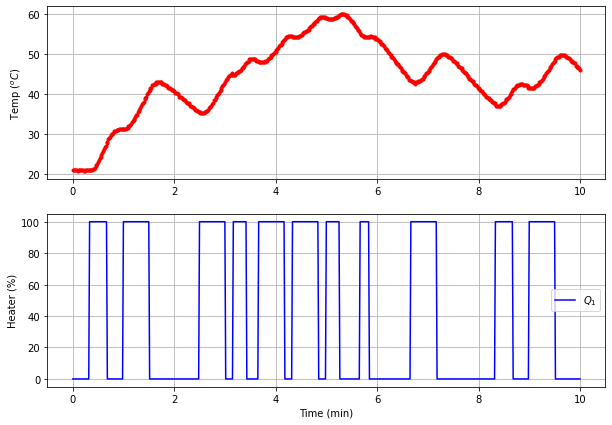

In [3]:
# Create Figure
plt.figure(figsize=(10,7))
ax = plt.subplot(2,1,1)
ax.grid()
plt.plot(tm/60.0,T1,'r.',label=r'$T_1$')
plt.ylabel(r'Temp ($^oC$)')
ax = plt.subplot(2,1,2)
ax.grid()
plt.plot(tm/60.0,Q1,'b-',label=r'$Q_1$')
plt.ylabel(r'Heater (%)')
plt.xlabel('Time (min)')
plt.legend()
plt.savefig('tclab_test.png')
plt.show()

### Generate Training Data

Random heater intervals that last 10-26 seconds every 5 to 180 seconds.

In [4]:
# generate new data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tclab
import time

n = 3600  # Number of second time points (60 min)
tm = np.linspace(0,n,n+1) # Time values
if tclab_connected:
    # TCLab hardware
    lab = tclab.TCLab()
else:
    # digital twin
    TCLab = tclab.setup(connected=False, speedup=100)
    lab = TCLab()
T1 = [lab.T1]
T2 = [lab.T2]
Q1 = np.zeros(n+1)
Q2 = np.zeros(n+1)

# random duration on (10-30 sec) in 60 second window
# cool down last 5 minutes
k = 60
for i in range(1,n-301):
    if (i%k)==0:
        j = np.random.randint(10,26)
        k = np.random.randint(5,180)
        Q1[i:i+j+1] = 100.0
for i in range(n):
    lab.Q1(Q1[i])
    lab.Q2(Q2[i])
    if tclab_connected:
        # sleep 1 second
        time.sleep(1)
        if i%10==0: print(Q1[i],lab.T1)
    else:
        # digital twin has 100x speedup
        time.sleep(0.01)
        # print every 250th cycle
        if i%250==0: print(Q1[i],lab.T1)
    T1.append(lab.T1)
    T2.append(lab.T2)
lab.close()
# Save data file
data = np.vstack((tm,Q1,Q2,T1,T2)).T
np.savetxt('tclab_train.csv',data,delimiter=',',\
           header='Time,Q1,Q2,T1,T2',comments='')

TCLab version 0.4.9
Simulated TCLab
0.0 20.949499999999997
0.0 39.3206
0.0 49.311899999999994
0.0 39.3206
0.0 52.8572
0.0 37.064499999999995
0.0 54.791
100.0 44.799699999999994
0.0 32.8746
0.0 47.700399999999995
100.0 35.452999999999996
0.0 31.585399999999996
0.0 36.7422
0.0 44.477399999999996
0.0 24.817099999999996
TCLab Model disconnected successfully.


### Create Plot of Training Data

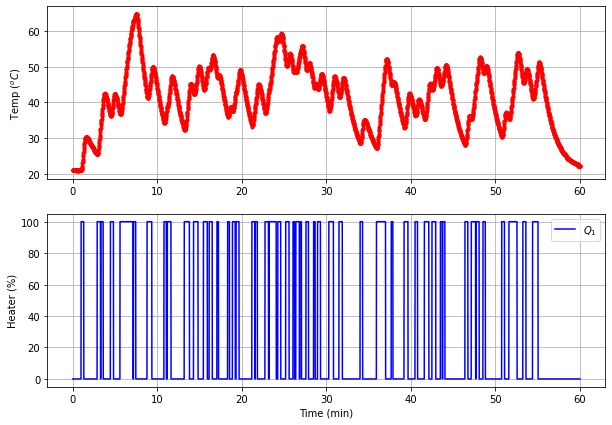

In [5]:
# Create Figure
plt.figure(figsize=(10,7))
ax = plt.subplot(2,1,1)
ax.grid()
plt.plot(tm/60.0,T1,'r.',label=r'$T_1$')
plt.ylabel(r'Temp ($^oC$)')
ax = plt.subplot(2,1,2)
ax.grid()
plt.plot(tm/60.0,Q1,'b-',label=r'$Q_1$')
plt.ylabel(r'Heater (%)')
plt.xlabel('Time (min)')
plt.legend()
plt.savefig('tclab_train.png')
plt.show()

### Train Classifier to Detect Heater Function

The [features of the data](https://apmonitor.com/pds/index.php/Main/FeatureEngineering) are selected and scaled (0-1) such as temperature, and temperature derivatives. The measured temperature and derivatives and heater value labels are used to create a classifier that predicts when the heater is on or off. The classifier is validated with new data that was not used for training.

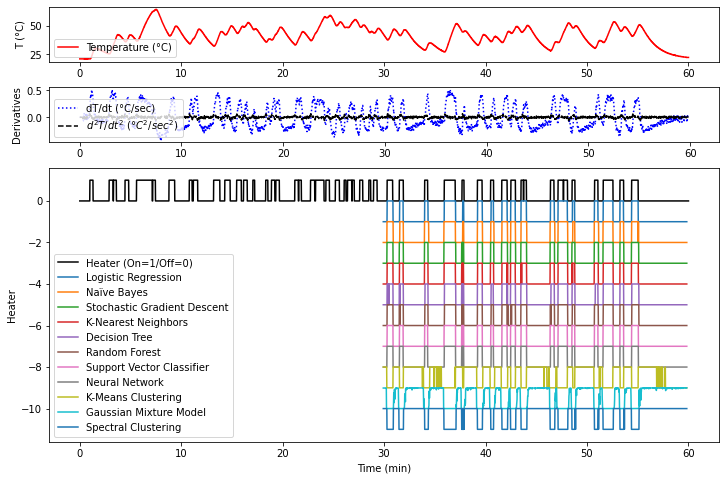

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# animate plot?
animate=False

# Load data
file1 = 'tclab_test.csv'
file2 = 'tclab_train.csv'
data = pd.read_csv(file2)

# Input Features: Temperature and 1st / 2nd Derivatives

# Cubic polynomial fit of temperature using 10 data points
data['dT1'] = np.zeros(len(data))
data['d2T1'] = np.zeros(len(data))
for i in range(len(data)):
    if i<len(data)-10:
        x = data['Time'][i:i+10]-data['Time'][i]
        y = data['T1'][i:i+10]
        p = np.polyfit(x,y,3)
        # evaluate derivatives at mid-point (5 sec)
        t = 5.0
        data['dT1'][i] = 3.0*p[0]*t**2 + 2.0*p[1]*t+p[2]
        data['d2T1'][i] = 6.0*p[0]*t + 2.0*p[1]
    else:
        data['dT1'][i] = np.nan
        data['d2T1'][i] = np.nan

# Remove last 10 values
X = np.array(data[['T1','dT1','d2T1']][0:-10])
y = np.array(data[['Q1']][0:-10])

# Scale data
# Input features (Temperature and 2nd derivative at 5 sec)
s1 = MinMaxScaler(feature_range=(0,1))
Xs = s1.fit_transform(X)
# Output labels (heater On / Off)
ys = [True if y[i]>50.0 else False for i in range(len(y))]

# Split into train and test subsets (50% each)
XA, XB, yA, yB = train_test_split(Xs, ys, \
                    test_size=0.5, shuffle=False)

# Plot regression results
def assess(P):
    plt.figure()
    plt.scatter(XB[P==1,0],XB[P==1,1],marker='^',color='blue',label='True')
    plt.scatter(XB[P==0,0],XB[P==0,1],marker='x',color='red',label='False')
    plt.scatter(XB[P!=yB,0],XB[P!=yB,1],marker='s',color='orange',\
                alpha=0.5,label='Incorrect')
    plt.legend()

# Supervised Classification

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')
lr.fit(XA,yA)
yP1 = lr.predict(XB)
#assess(yP1)

# Naïve Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(XA,yA)
yP2 = nb.predict(XB)
#assess(yP2)

# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='modified_huber', shuffle=True,random_state=101)
sgd.fit(XA,yA)
yP3 = sgd.predict(XB)
#assess(yP3)

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(XA,yA)
yP4 = knn.predict(XB)
#assess(yP4)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=10,random_state=101,\
                               max_features=None,min_samples_leaf=5)
dtree.fit(XA,yA)
yP5 = dtree.predict(XB)
#assess(yP5)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfm = RandomForestClassifier(n_estimators=70,oob_score=True,n_jobs=1,\
                  random_state=101,max_features=None,min_samples_leaf=3)
rfm.fit(XA,yA)
yP6 = rfm.predict(XB)
#assess(yP6)

# Support Vector Classifier
from sklearn.svm import SVC
svm = SVC(gamma='scale', C=1.0, random_state=101)
svm.fit(XA,yA)
yP7 = svm.predict(XB)
#assess(yP7)

# Neural Network
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs',alpha=1e-5,max_iter=200,\
                    activation='relu',hidden_layer_sizes=(10,30,10),\
                    random_state=1, shuffle=True)
clf.fit(XA,yA)
yP8 = clf.predict(XB)
#assess(yP8)

# Unsupervised Classification

# K-Means Clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit(XA)
yP9 = km.predict(XB)
# Arbitrary labels with unsupervised clustering may need to be reversed
#yP9 = 1.0-yP9
#assess(yP9)

# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(XA)
yP10 = gmm.predict_proba(XB) # produces probabilities
# Arbitrary labels with unsupervised clustering may need to be reversed
yP10 = 1.0-yP10[:,0]

# Spectral Clustering
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2,eigen_solver='arpack',\
                        affinity='nearest_neighbors')
yP11 = sc.fit_predict(XB) # No separation between fit and predict calls
                        #  need to fit and predict on same dataset
# Arbitrary labels with unsupervised clustering may need to be reversed
#yP11 = 1.0-yP11
#assess(yP11)

plt.figure(figsize=(12,8))

if animate:
    plt.ion()
    plt.show()
    make_gif = True
    try:
        import imageio  # required to make gif animation
    except:
        print('install imageio with "pip install imageio" to make gif')
        make_gif=False
    if make_gif:
        try:
            import os
            images = []
            os.mkdir('./frames')
        except:
            print('Figure directory already created')
            
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,5])
plt.subplot(gs[0])
plt.plot(data['Time']/60,data['T1'],'r-',\
         label='Temperature (°C)')
plt.ylabel('T (°C)')
plt.legend(loc=3)
plt.subplot(gs[1])
plt.plot(data['Time']/60,data['dT1'],'b:',\
         label='dT/dt (°C/sec)')    
plt.plot(data['Time']/60,data['d2T1'],'k--',\
         label=r'$d^2T/dt^2$ ($°C^2/sec^2$)')
plt.ylabel('Derivatives')
plt.legend(loc=3)

plt.subplot(gs[2])
plt.plot(data['Time']/60,data['Q1']/100,'k-',\
         label='Heater (On=1/Off=0)')

t2 = data['Time'][len(yA):-10].values
plt.plot(t2/60,yP1-1,label='Logistic Regression')
plt.plot(t2/60,yP2-2,label='Naïve Bayes')
plt.plot(t2/60,yP3-3,label='Stochastic Gradient Descent')
plt.plot(t2/60,yP4-4,label='K-Nearest Neighbors')
plt.plot(t2/60,yP5-5,label='Decision Tree')
plt.plot(t2/60,yP6-6,label='Random Forest')
plt.plot(t2/60,yP7-7,label='Support Vector Classifier')
plt.plot(t2/60,yP8-8,label='Neural Network')
plt.plot(t2/60,yP9-9,label='K-Means Clustering')
plt.plot(t2/60,yP10-10,label='Gaussian Mixture Model')
plt.plot(t2/60,yP11-11,label='Spectral Clustering')

plt.ylabel('Heater')
plt.xlabel(r'Time (min)')
plt.legend(loc=3)

if animate:
    t = data['Time'].values/60
    n = len(t)
    for i in range(60,n+1,10):
        for j in range(3):
            plt.subplot(gs[j])
            plt.xlim([t[max(0,i-1200)],t[i]])        
        filename='./frames/frame_'+str(1000+i)+'.png'
        plt.savefig(filename)
        if make_gif:
            images.append(imageio.imread(filename))
        plt.pause(0.1)

    # create animated GIF
    if make_gif:
        imageio.mimsave('animate.gif', images)
        imageio.mimsave('animate.mp4', images)
else:
    plt.show()

### Exercise

Simulate intermittent heater failure by turning down the heater power every other cycle. Each cycle is 30 seconds. The heater power is set with **lab.P1**. The heater power can be set from *0* to *255* and is set to *200* by default. The simulated cyber-attack turns off the heater by setting **lab.P1=0** so that no energy is applied even though the heater is requested to 100% on with **lab.Q1(100)**. Sample code without the classifier is provided below.

In [7]:
import tclab
import time

if tclab_connected:
    # TCLab hardware
    lab = tclab.TCLab()
else:
    # digital twin
    TCLab = tclab.setup(connected=False, speedup=100)
    lab = TCLab()  

# simulated cyber attack
print('Power Level (0-255): ' + str(lab.P1))

# test cyber attack
print('-'*40)
print('Heater Power Off')
print('Temperature (degC): ' + str(lab.T1))
lab.P1=0      # set heater 1 power level to zero
print('Power Level (0-255): ' + str(lab.P1))
lab.Q1(100)   # turn on heater but no power (P1=0)
if tclab_connected:
    print('Wait 30 sec')
    time.sleep(30)
else:
    print('Wait 30 simulated sec')
    time.sleep(0.3)
    
print('Temperature (degC): ' + str(lab.T1))

print('-'*40)
print('Heater Power On')
print('Temperature (degC): ' + str(lab.T1))
lab.P1 = 200  # restore heater 1 power level
print('Power Level (0-255): ' + str(lab.P1))
lab.Q1(100)   # turn on heater with power (P1=250)
if tclab_connected:
    print('Wait 30 sec')
    time.sleep(30)
else:
    print('Wait 30 simulated sec')
    time.sleep(0.3)
print('Temperature (degC): ' + str(lab.T1))

TCLab version 0.4.9
Simulated TCLab
Power Level (0-255): 200.0
----------------------------------------
Heater Power Off
Temperature (degC): 20.949499999999997
Power Level (0-255): 0
Wait 30 simulated sec
Temperature (degC): 20.949499999999997
----------------------------------------
Heater Power On
Temperature (degC): 20.949499999999997
Power Level (0-255): 200
Wait 30 simulated sec
Temperature (degC): 27.3955


Use the classifier to detect when the heater has malfunctioned or is the target of a simulated [cyberattack](https://apmonitor.com/pds/index.php/Main/CyberSecurity) (the power is set to zero or the heater power supply is unplugged). The sampling frequency can be adjusted to a faster interval, if needed.

In [45]:
# generate data with simulated cyberattack
if tclab_connected:
    # TCLab hardware
    lab = tclab.TCLab()
else:
    # digital twin
    TCLab = tclab.setup(connected=False, speedup=50)
    lab = TCLab()    

n = 600  # Number of second time points (10 min)
tm = np.linspace(0,n,n+1) # Time values
T1 = [lab.T1]
T2 = [lab.T2]
Q1 = np.zeros(n+1)
Q2 = np.zeros(n+1)
dT1 = np.zeros(n+1)
d2T1 = np.zeros(n+1)
# turn on heater at select times
Q1[20:41]   = 100.0; Q1[60:91]   = 100.0; Q1[150:181] = 100.0
Q1[190:206] = 100.0; Q1[220:251] = 100.0; Q1[260:291] = 100.0
Q1[300:316] = 100.0; Q1[340:351] = 100.0; Q1[400:431] = 100.0
Q1[500:521] = 100.0; Q1[540:571] = 100.0

# 30 sec "cyberattacks" starting at 70, 140, 400 sec
P1 = np.ones(n+1)*200
P1[70:100]  = 0
P1[140:170] = 0
P1[400:431] = 0

# Detection
D1 = np.zeros(n+1)

# classifiers
clfs = [lr,nb,sgd,knn,dtree,rfm,svm,clf]
pred = np.zeros((n+1,8))

for i in range(n):
    lab.Q1(Q1[i]); lab.Q2(Q2[i])
    lab.P1 = P1[i]
    if tclab_connected:
        # sleep 1 second
        time.sleep(1)
        if i%10==0: print(Q1[i],lab.T1)
    else:
        # digital twin has 100x speedup
        time.sleep(0.01)
        # print every 50th cycle
        if i%100==0: print(Q1[i],lab.T1)
    T1.append(lab.T1); T2.append(lab.T2)

    # start detection when above 10 samples
    if i>=10:
        # Cubic polynomial fit of temperature using 10 data points
        x = tm[i-10:i+1]
        y = T1[i-10:i+1]
        p = np.polyfit(x,y,3)
        # evaluate derivatives at mid-point (5 sec)
        t = tm[i-5]
        dT1[i-5]  = 3.0*p[0]*t**2 + 2.0*p[1]*t+p[2]
        d2T1[i-5] = 6.0*p[0]*t + 2.0*p[1]
        X = np.array([T1[i-5],dT1[i-5],d2T1[i-5]])
        Xs = s1.transform(X.reshape(1, -1)).reshape(1, -1)
                
        # classifier predictions
        for j,c in enumerate(clfs):
            pred[i-5,j] = c.predict(Xs)

        # update detection threshold
        command = Q1[i-5]/100
        predict = np.mean(pred[i-5,:])
        alpha   = 0.1
        D1[i-5] = (1-alpha)*D1[i-6] + alpha*np.abs(predict-command)

lab.close()

TCLab version 0.4.9
Simulated TCLab
0.0 20.949499999999997
0.0 32.8746
100.0 32.8746
100.0 54.14639999999999
100.0 41.898999999999994
100.0 27.717799999999997
TCLab Model disconnected successfully.


### Generate Plot of Results

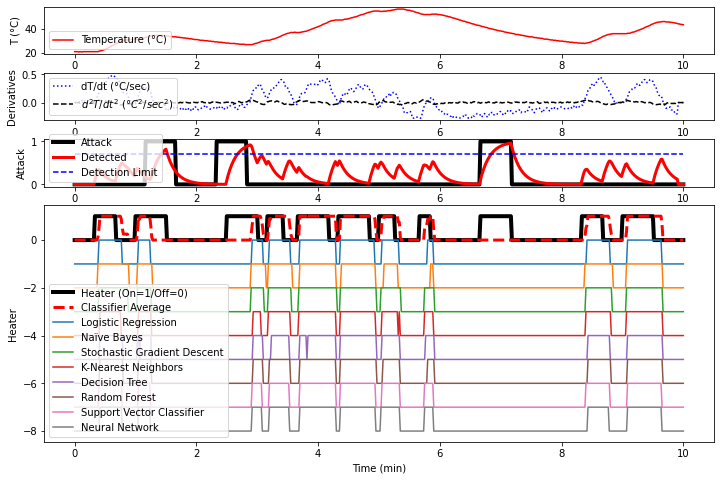

In [49]:
plt.figure(figsize=(12,8))
            
gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,5])

plt.subplot(gs[0])
plt.plot(tm/60,T1,'r-',label='Temperature (°C)')
plt.ylabel('T (°C)')
plt.legend(loc=3)

plt.subplot(gs[1])
plt.plot(tm/60,dT1,'b:',label='dT/dt (°C/sec)')    
plt.plot(tm/60,d2T1,'k--',label=r'$d^2T/dt^2$ ($°C^2/sec^2$)')
plt.ylabel('Derivatives')
plt.legend(loc=3)

plt.subplot(gs[2])
plt.plot(tm/60,1-np.array(P1)/200,'k-',lw=4,label='Attack')
plt.plot(tm/60,D1,'r-',lw=3,label='Detected')
plt.plot([0,tm[-1]/60],[0.7,0.7],'--',color='blue',label='Detection Limit')
plt.legend(loc=3)
plt.ylabel('Attack')

plt.subplot(gs[3])
plt.plot(tm/60,Q1/100,'k-',lw=4,label='Heater (On=1/Off=0)')
yP = np.mean(pred,1) # row averages
plt.plot(tm/60,yP,'r--',lw=3,label='Classifier Average')
plt.plot(tm/60,pred[:,0]-1,label='Logistic Regression')
plt.plot(tm/60,pred[:,1]-2,label='Naïve Bayes')
plt.plot(tm/60,pred[:,2]-3,label='Stochastic Gradient Descent')
plt.plot(tm/60,pred[:,3]-4,label='K-Nearest Neighbors')
plt.plot(tm/60,pred[:,4]-5,label='Decision Tree')
plt.plot(tm/60,pred[:,5]-6,label='Random Forest')
plt.plot(tm/60,pred[:,6]-7,label='Support Vector Classifier')
plt.plot(tm/60,pred[:,7]-8,label='Neural Network')

plt.ylabel('Heater')
plt.xlabel(r'Time (min)')
plt.legend(loc=3)
plt.savefig('detection.png',dpi=300)